In [1]:
import sys
sys.path.append('C:/Users/320060820/experiments/')
import fxp_quantize
import model_data

import keras
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [2]:
bw_range = np.arange(1, 11, 1)
f_range_w = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/'
dataset = 'Keras_SVHN/'
scores_svhn_w = np.load(output_path + 'Weights/' + dataset + 'scores_1_w.npy')
scores_svhn_a = np.load(output_path + 'Activations/' + dataset + 'scores_1.npy')
f_range_a = np.arange(-4, 10, 1)

In [3]:
save_path = 'C:/Users/320060820/experiments/test_models/'

In [6]:
name = 'mnist_keras'
model_path = 'mnist_custom/mnist_keras_large.h5'

from test_models.mnist_custom import data
_, test_data = data.get_data()

keras_mnist = model_data.Model(name, test_data, path=save_path+model_path)

In [12]:
layer_name = 'conv2d_2'
keras_mnist.load_model_from_path()

original_weights = keras_mnist.get_model_weights_by_layer()[1]

keras_mnist.model = fxp_quantize.quantize_weights(keras_mnist.model, 3, 4, layer_name=[layer_name])

quantized_weights = keras_mnist.get_model_weights_by_layer()[1]

original_activations = keras_mnist.get_activation_maps(keras_mnist.x_test[:50], layer_name)

from model_gen import keras_cnn

mnist_arch = keras_cnn.KerasCNN((28, 28, 1), 10, 'C:/Users/320060820/experiments/test_models/mnist_custom/mnist_keras_w.h5')
keras_model = model_data.Model('lol', test_data, model=mnist_arch.get_fxp_model({layer_name:[5, 2]}))
quant_activations = keras_model.get_activation_maps(keras_model.x_test[:50], 'lambda_1')

AttributeError: 'list' object has no attribute 'flatten'

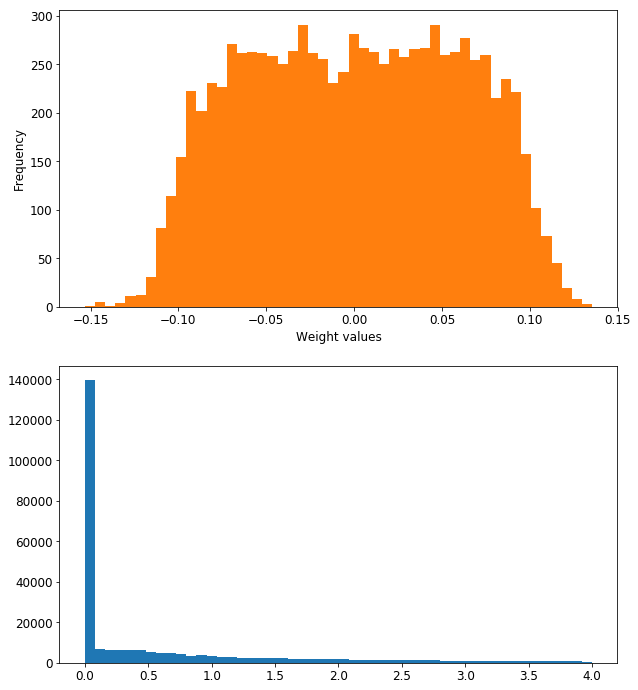

In [13]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
ax = ax.flat
ax[0].hist(original_weights[0].flatten(), bins=50, label='original weights');
ax[0].hist(quantized_weights[0].flatten(), bins=50, label='quantized weights');
ax[0].set_xlabel('Weight values')
ax[0].set_ylabel('Frequency')
ax[1].hist(original_activations.flatten(), bins=50, label='original activations', range=(0, 4));
ax[1].hist(quant_activations.flatten(), bins=50, label='quantized activations');
ax[1].set_xlabel('Activation values')
ax[1].set_ylabel('Frequency')
ax[0].legend();
ax[1].legend();
fig.savefig('C:/Users/320060820/Onedrive - Philips/Thesis docs/Images/quantized_distributions.png', bbox_inches='tight')

In [35]:
keras_mnist.load_model_from_path()
original_weights = keras_mnist.get_model_weights_by_layer()[1][0]
quant_weights = []
test_cases = [(7, 7), (5, 7), (4, 7), (4, 8), (5, 8)]
for x in test_cases:
    keras_mnist.load_model_from_path()
    keras_mnist.model = fxp_quantize.quantize_weights(keras_mnist.model, x[0], x[1], layer_name=['conv2d_2'])
    quant_weights.append(keras_mnist.get_model_weights_by_layer()[1][0])

In [34]:
np.ceil(np.log2(0.15*2**7 * 2 + 1)) + 1

7.0

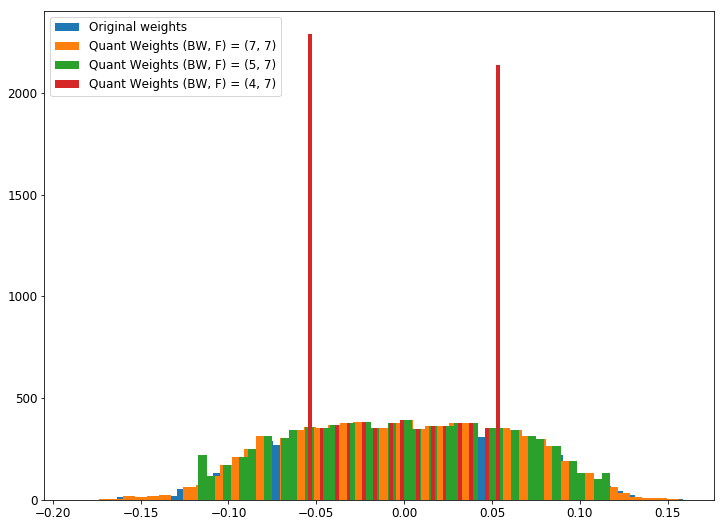

In [43]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plt.figure(figsize=(12, 9))
plt.hist(original_weights.flatten(), bins=50, label='Original weights')
for i in range(len(quant_weights) - 2):
    plt.hist(quant_weights[i].flatten(), bins=50, label=f'Quant Weights (BW, F) = ({test_cases[i][0]}, {test_cases[i][1]})')
# fig.savefig('C:/Users/320060820/Onedrive - Philips/Thesis docs/Images/quantized_distributions.png')
plt.legend();
# plt.grid();

In [3]:
def plot_results(scores, layer_names, rows, columns, figsize, bw_range, f_range, invert=False, vmax=None):
    
    plt.rcParams.update({'font.size': 12, 'font.weight':520})
    if len(scores.shape) < 3:
        scores = np.expand_dims(scores, axis=3)
    fig, ax = plt.subplots(rows, columns, figsize=figsize)
    cbar_ax = fig.add_axes([.91, 0.1, .02, 0.8])
    if rows == 1 and columns == 1:
        ax = [ax]
    else:
        ax = ax.flatten()
    vmin = scores.min()
    if vmax is None:
        vmax = scores.max()
    else:
        vmax=vmax
    t = np.arange(0.0, vmax, 0.1).tolist()
    for i in range(scores.shape[2]):
        sns.heatmap(scores[:, :, i], annot=True, fmt='.3f', ax=ax[i], xticklabels=f_range, 
                    yticklabels=bw_range, vmin = vmin, vmax=vmax, cbar_ax=cbar_ax)#, cbar_kws={"ticks":t})
        ax[i].set_xlabel('Fractional offset')
        ax[i].set_ylabel('Bitwidth')
        ax[i].set_title(f'Layer {layer_names[i]}')
        if invert:
            ax[i].invert_yaxis()
    if rows*columns - scores.shape[2] != 0:
        for i in range(1, rows*columns - scores.shape[2] + 1):
            fig.delaxes(ax[-i])

In [9]:
def plot_weight_scores(score_w, bw_range, f_range, save_path):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    vmin = score_w.min()
    vmax = score_w.max()
    sns.heatmap(score_w, annot=True, fmt='.3f', ax=ax, xticklabels=f_range, 
                yticklabels=bw_range, vmin = score_w.min(), vmax=0.8)
    ax.set_xlabel('Fractional offset')
    ax.set_ylabel('Bitwidth')
    fig.savefig(save_path)

In [5]:
def plot_activations_scores(score_a, bw_range, f_range, save_path):
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    vmin = score_a.min()
    vmax = score_a.max()
    sns.heatmap(score_a, annot=True, fmt='.3f', ax=ax, xticklabels=f_range, 
                yticklabels=bw_range, vmin = score_a.min(), vmax=0.8, cbar_ax=cbar_ax)
    ax.set_xlabel('Fractional offset')
    ax.set_ylabel('Bitwidth')
    fig.savefig(save_path)

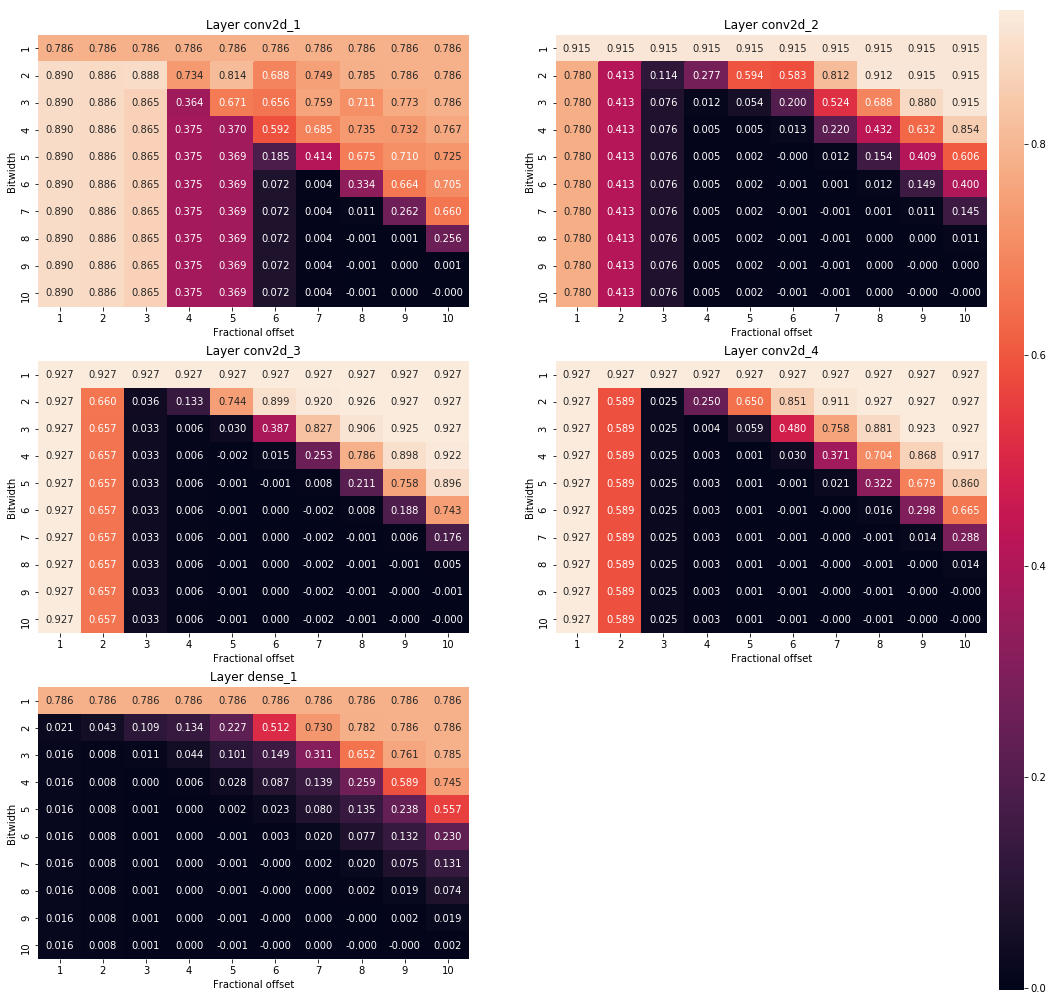

In [19]:
plt.rcParams.update({'font.size': 10, 'font.weight':'medium'})
plot_results(scores_svhn_w, layer_names, 3, 2, (17, 17), bw_range, f_range_w)
plt.savefig('C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_svhn_w.png')

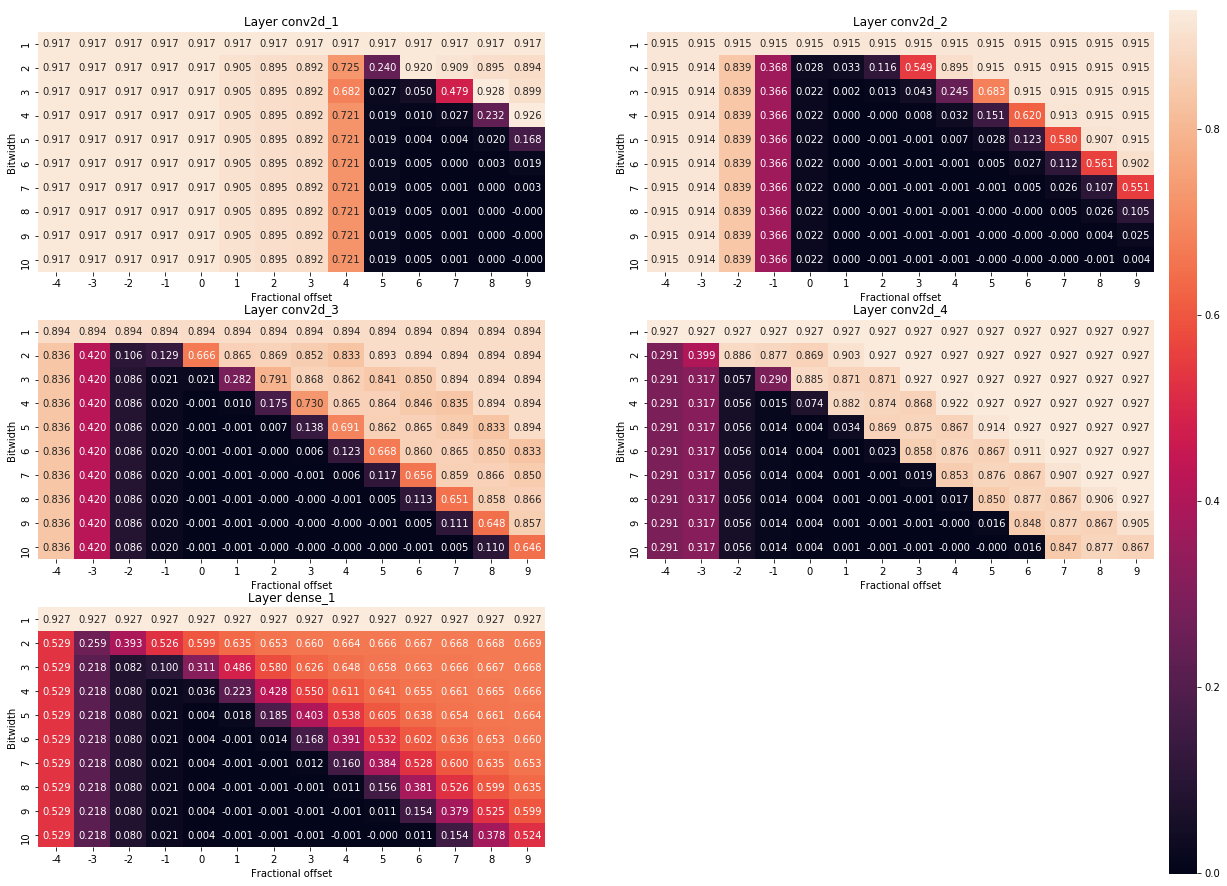

In [27]:
plot_results(scores_svhn_a, layer_names, 3, 2, (20, 15), bw_range, f_range_a)

In [38]:
score_w = scores_svhn_w[:, :, 1]
score_a = scores_svhn_a[:, :, 1]

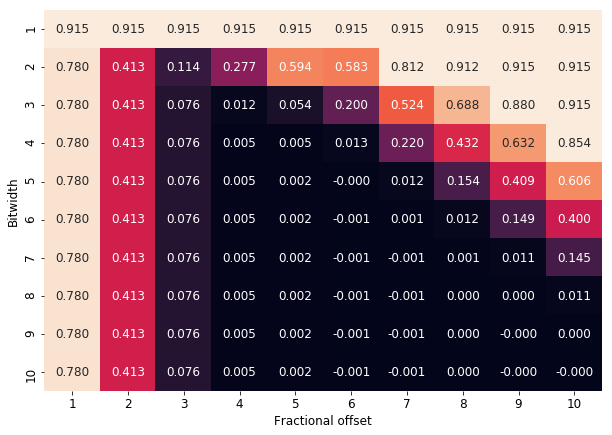

In [42]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plot_weight_scores(score_w, bw_range, f_range_w, 
                   'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_svhn_w_layer2.png')

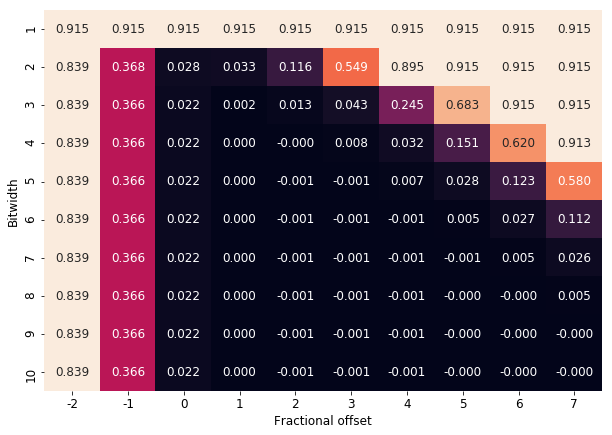

In [51]:
plt.rcParams.update({'font.size': 12, 'font.weight':'medium'})
plot_activations_scores(score_a[:, 2:12], bw_range, f_range_a[2:12],
                       'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_svhn_a_layer2.png')

In [6]:
bw_range = np.arange(1, 11, 1)
f_range_w = np.arange(1, 11, 1)
layer_names = [f'conv2d_{i}' for i in range(1, 5)] + ['dense_1']
output_path = 'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/'
dataset = 'Keras_MNIST/'
scores_mnist_w = np.load(output_path + 'Weights/' + dataset + 'scores_1_w.npy')
scores_mnist_a = np.load(output_path + 'Activations/' + dataset + 'scores_1.npy')
f_range_a = np.arange(-4, 10, 1)

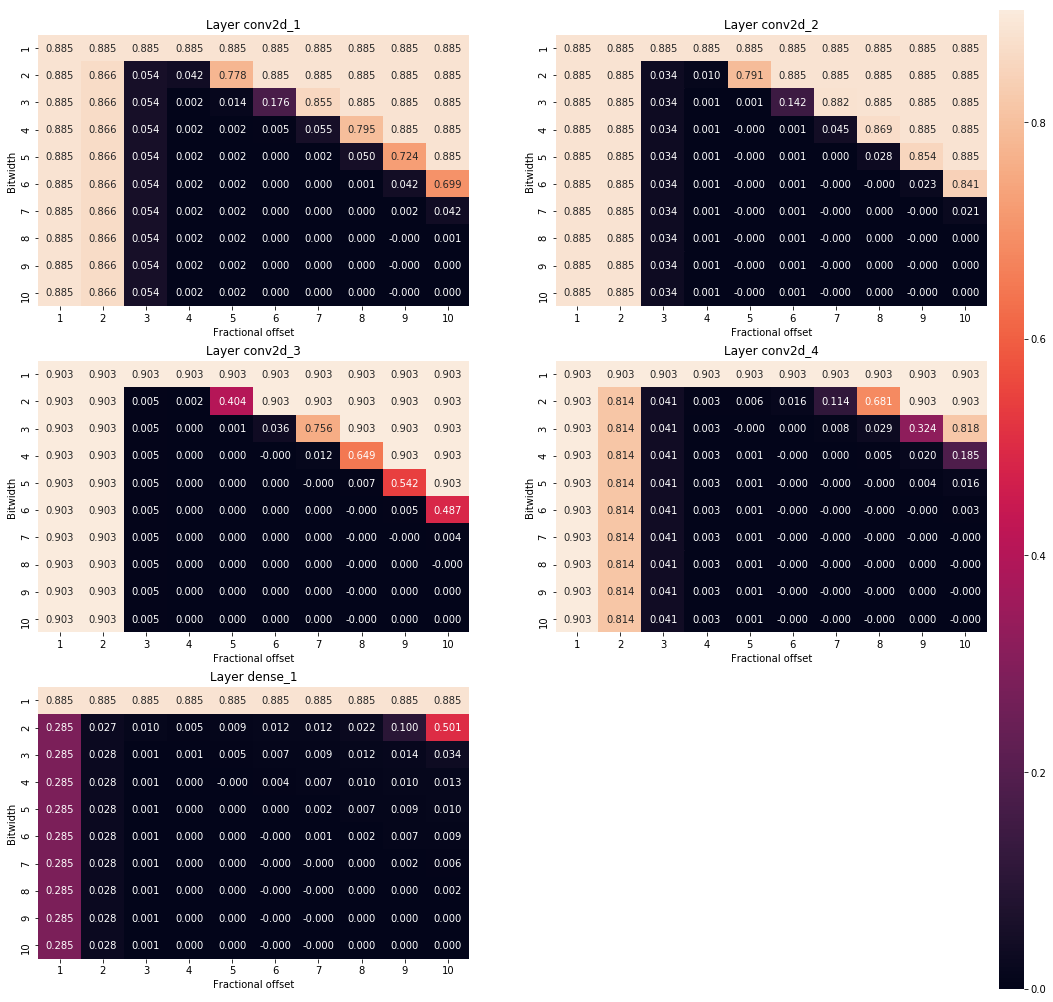

In [55]:
plt.rcParams.update({'font.size': 10, 'font.weight':'medium'})
plot_results(scores_mnist_w, layer_names, 3, 2, (17, 17), bw_range, f_range_w)
# plt.savefig('C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_mnist_w.png')

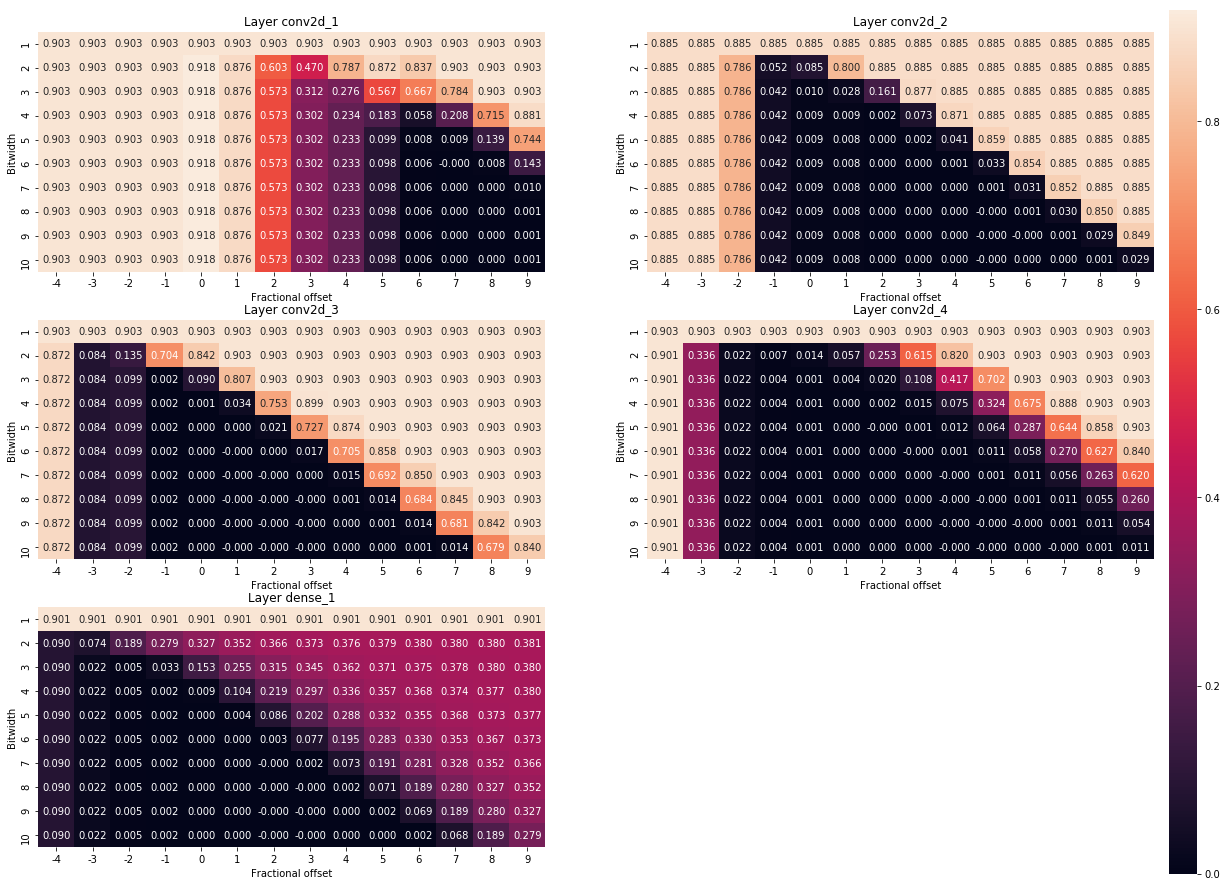

In [57]:
plot_results(scores_mnist_a, layer_names, 3, 2, (20, 15), bw_range, f_range_a)

In [7]:
score_w = scores_mnist_w[:, :, 1]
score_a = scores_mnist_a[:, :, 1]

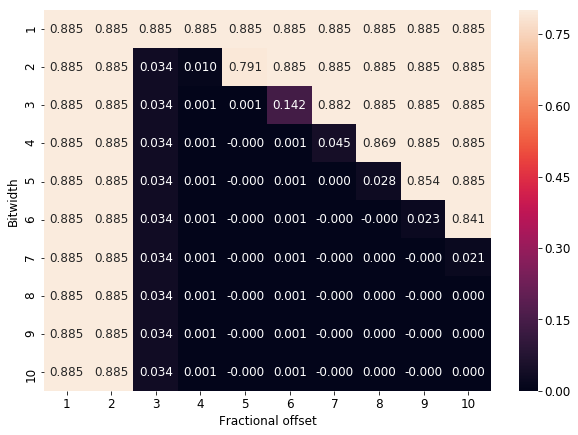

In [10]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plot_weight_scores(score_w, bw_range, f_range_w, 
                   'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_mnist_w_layer2.png')

In [17]:
scores_mnist_w = np.load(output_path + 'Weights/' + dataset + 'scores_1_1.npy')

In [18]:
scores_ww = scores_mnist_w[:, :, 0]

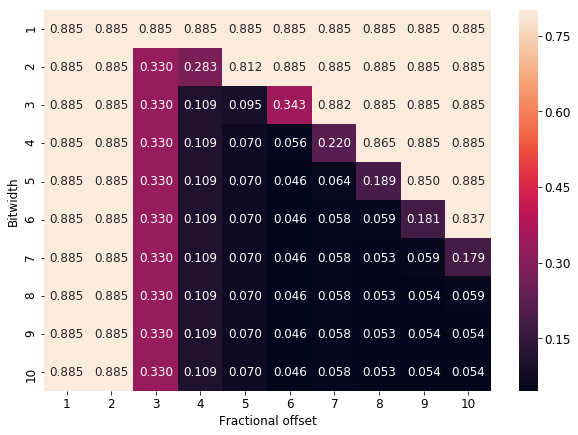

In [19]:
plt.rcParams.update({'font.size': 12, 'font.weight':520})
plot_weight_scores(scores_ww, bw_range, f_range_w, 
                   'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_mnist_w_layer2_dep2.png')

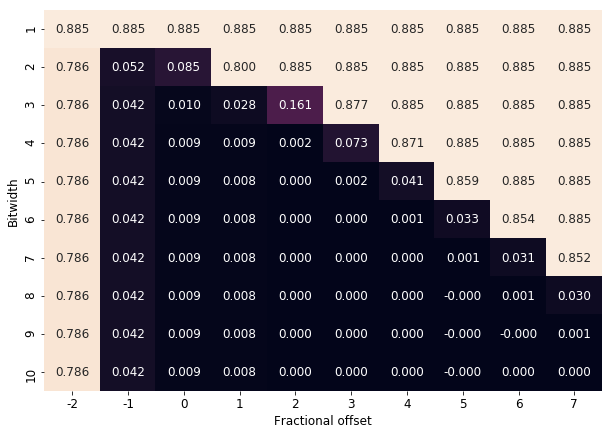

In [60]:
plt.rcParams.update({'font.size': 12, 'font.weight':'medium'})
plot_activations_scores(score_a[:, 2:12], bw_range, f_range_a[2:12],
                       'C:/Users/320060820/experiments/outputs/Brute_Force_Analysis/BF_mnist_a_layer2.png')